<a href="https://colab.research.google.com/github/harnalashok/LLMs/blob/main/chromadbExpts%20and%20exports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 01st June, 2024
# Objectives: a. Understand chromadb vector store
#             b. Experiment with its functions
#             c. Export chroma store into json format
#                and store it in HuggingFace repo for use
#                by others.
#                (Exporting chromadb to csv is not possible
#                 because of nature of data)

## References:
> a. [Huggingface](https://huggingface.co/chromadb)    
> b. [GitHub-1](https://github.com/chroma-core/chroma_datasets/tree/master)    
> c. [GitHub-2](https://github.com/johnnycode8/chromadb_quickstart/tree/main)      
> d. [Analytics Vidya](https://www.analyticsvidhya.com/blog/2023/07/guide-to-chroma-db-a-vector-store-for-your-generative-ai-llms/)    
> e. [chromadb cookbook](https://cookbook.chromadb.dev/)

>In traditional databases, data is typically stored in rows and columns, suitable for structured data. However, as datasets become more complex and high-dimensional, the need for a more specialized solution & data structures arises. This is where vector databases shine. Instead of dealing with traditional data structures, vector databases are optimized to handle vectors - mathematical representations of data points in multi-dimensional spaces.

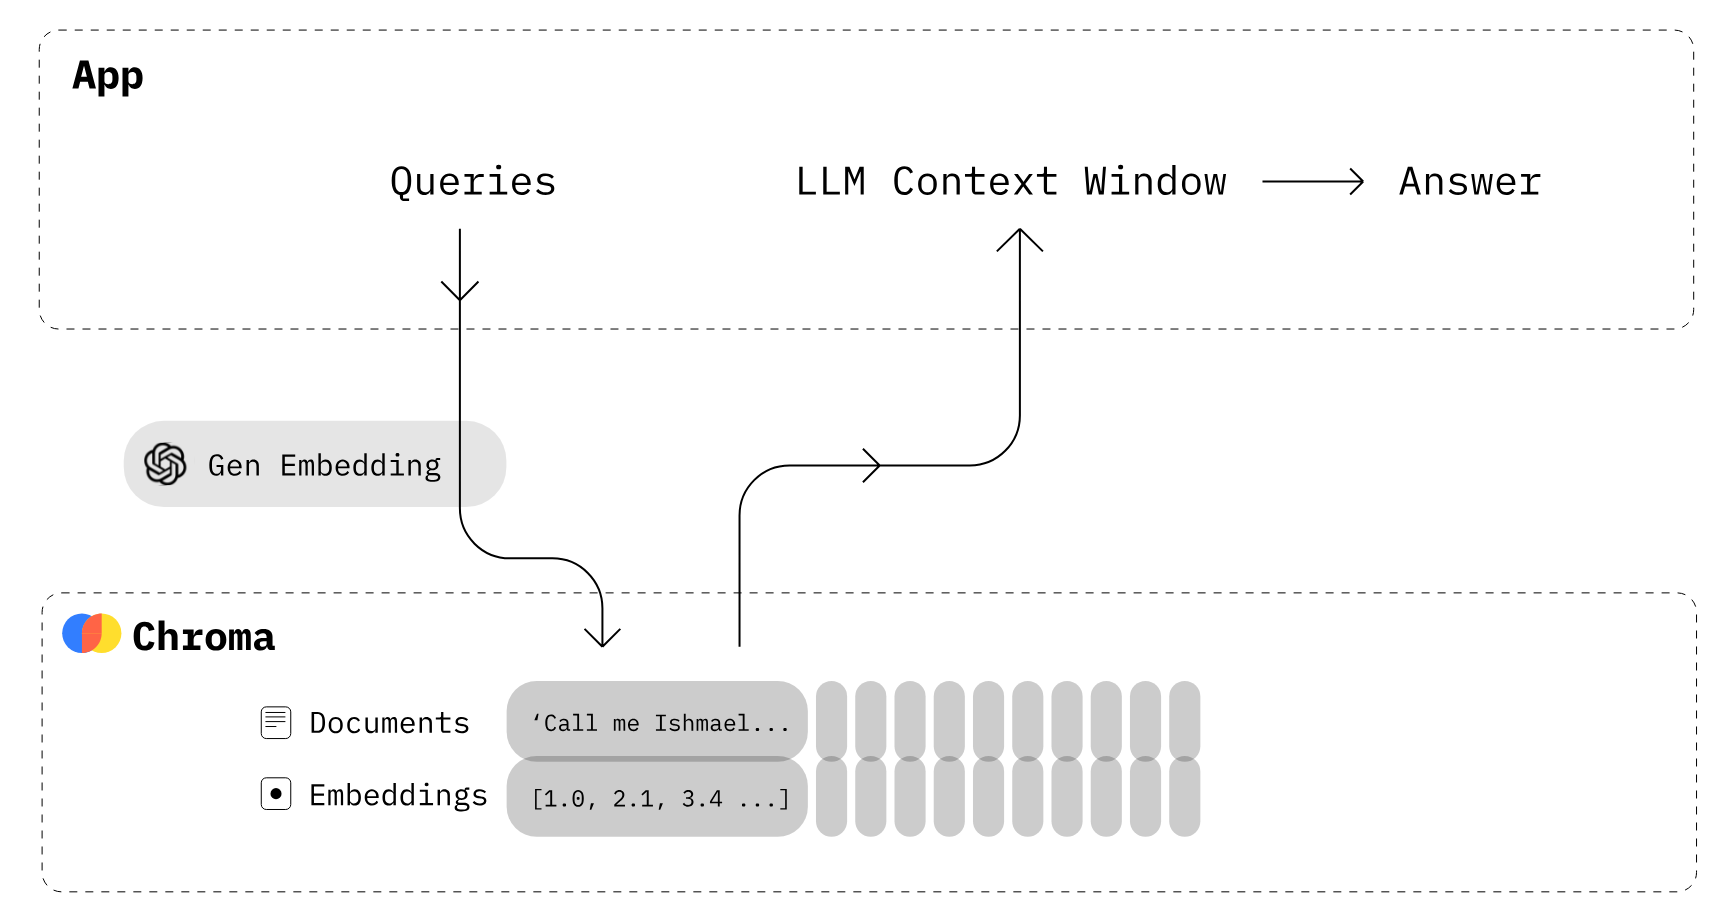

In [ ]:
# 1.0 chroma db is installed as a python package
#       not as an ubuntu software:

! pip install chromadb

## Why chromadb?
Here are the steps describing how Chroma DB works:

- **Data Structure**: Chroma DB organizes chromatic data in a structured format optimized for efficient storage and retrieval.
- **Storage**: It stores metadat also. For images, it stores color-related information such as RGB values, color names, and associated metadata in the database.
- **Indexing**: Metadata is indexed. Chroma DB creates indexes to facilitate fast lookup of colors based on various criteria like RGB values, color names, or other attributes.
- **Querying**: Query can include metadata. Users can query Chroma DB using specific criteria such as color codes, names, or properties to retrieve relevant color information.
- **Analysis**: Chroma DB enables analysis of color data for various applications such as image processing, design, and color matching.
- **Optimization**: The database is optimized for speed and efficiency, allowing for quick retrieval and processing of color-related information.
- **Integration**: It can be integrated into different software applications and platforms to provide color-related functionalities seamlessly.
- **Continued Improvement**: Chroma DB may undergo updates and improvements to enhance its capabilities and accommodate evolving requirements in color management and analysis.


### Structure
Refer Concepts [here](https://cookbook.chromadb.dev/core/concepts/#embedding-vector) <br>

- Tenants: A tenant is a logical grouping of databases. Default is `DEFAULT_TENANT`
- Databases: A database is a logical grouping of collections (tables). Default is `DEFAULT_DATABASE`
- Collections are the grouping mechanism for embeddings, documents, and metadata.

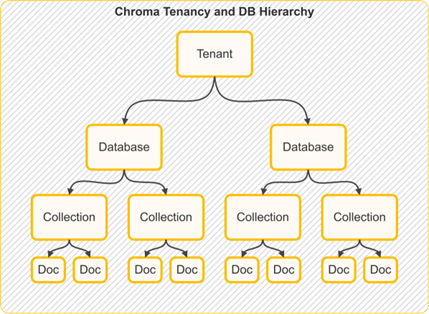

#### Metadata¶

Metadata is a dictionary of key-value pairs that can be associated with an embedding. Metadata is stored in the database and can be queried for.

Metadata values can be of the following types:

>strings<br>
>integers<br>
>floats (float32)<br>
>booleans<br>


#### File Storage
Refer Concepts [here](https://cookbook.chromadb.dev/core/concepts/#embedding-vector) <br>
>Document and Metadata Index¶

>>The document and metadata index is stored in SQLite database.<br>

>Vector Index (HNSW Index)¶<br>

>>Under the hood Chroma uses its own library, HNSW lib, for indexing and searching vectors.

>>In a single-node mode, Chroma will create a single HNSW index for each collection. The index is stored in a subdir of your persistent dir, named after the collection id (UUID-based).

>>The HNSW lib uses fast ANN algo to search the vectors in the index.

In [ ]:
# 1.0
# chroma cookbook: https://cookbook.chromadb.dev/core/tenants-and-databases/
# chroma db has Tenants: A tenant is a logical grouping of databases.
# chromadb has Databases: A database is a logical grouping of collections (tables).

import chromadb
from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

## Clients

chroma has tow types of clients unlike in databases. One client (PersistentClient) is suited only for local chroma server and the other client (HttpClient) for remote chroma server.

In [ ]:
# 1.1 Create a localclient:
# https://cookbook.chromadb.dev/core/clients/#persistent-client

# 1.1.1 No host is specified. Understood to be the same where this code runs:
myclient = chromadb.PersistentClient(
                                      path="/content/",      # Where data will be stored
                                      settings=Settings(),   # Default settungs
                                      tenant=DEFAULT_TENANT, # Default
                                      database=DEFAULT_DATABASE,
                                     )


In [ ]:
# 1.1.2  YOu can try this also. But host has to be specified.
#        But in colab, it will not work as in colab, there is no localhost:
#        Ref: https://cookbook.chromadb.dev/core/clients/#http-client

client = chromadb.HttpClient(
                              host="localhost",
                              port=8000,
                              ssl=False,
                              headers=None,
                              settings=Settings(),
                              tenant=DEFAULT_TENANT,
                              database=DEFAULT_DATABASE,
                          )

## Collections

Collection in Vector Store is where we save the set of a) vector embeddings, b) documents, and c) any metadata, if present. Collection in a vector database can be thought of as a Table in Relational Database.

### [Collection Properties](https://cookbook.chromadb.dev/core/collections/#collection-properties)¶

Each collection is characterized by the following properties:

- name: The name of the collection. The name can be changed as long as it is unique within the database ( use collection.modify(new_name="new_name") to change the name of the collection
- metadata: A dictionary of metadata associated with the collection. The metadata is a dictionary of key-value pairs. Keys can be strings, values can be strings, integers, floats, or booleans. Metadata can be changed using collection.modify(new_metadata={"key": "value"}) (Note: Metadata is always overwritten when modified)
- embedding_function: The embedding function used to embed documents in the collection.

Defaults:

- Embedding Function - by default if `embedding_function` parameter is not provided at `get()` or `create_collection()` or `get_or_create_collection()` time, Chroma uses `chromadb.utils.embedding_functions`.`DefaultEmbeddingFunction` which uses the chromadb.`utils.embedding_functions`.`DefaultEmbeddingFunction` to embed documents. The default embedding function uses `Onnx Runtime` with `all-MiniLM-L6-v2` model. **Sentence transformer** model will be downloaded when we add documents to collection. Refer [here](https://docs.trychroma.com/guides/embeddings#default:-all-minilm-l6-v2) for documentation on *Embeddings*.        

-distance metric - by default Chroma use L2 (Euclidean Distance Squared) distance metric for newly created collection. You can change it at creation time using hnsw:space metadata key. Possible values are l2, cosine, and 'ip' (inner product)

### Embedding functions
Embedding functions can be linked to a collection and used whenever you call `add`, `update`, `upsert` or `query`. You can also use them directly which can be handy for debugging. Here is an example of using them directly:

By default, Chroma uses the **Sentence Transformers** `all-MiniLM-L6-v2` model to create embeddings. This embedding model can create sentence and document embeddings that can be used for a wide variety of tasks. This embedding function runs locally on your machine, and may require you download the model files (this will happen automatically).

In [ ]:
# 2.0
from chromadb.utils import embedding_functions
default_ef = embedding_functions.DefaultEmbeddingFunction()
val = default_ef(["foo"])
val[0][:3]

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:03<00:00, 25.7MiB/s]


[0.016233395785093307, -0.0076623898930847645, 0.018606433644890785]

Chroma can also use any **Sentence Transformers** model to create embeddings.    
List of all Sentence Transformer models is [here](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)

In [ ]:
# 2.1 You have to first install sentence_transformers package:
! pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# 2.2 The model will first be downloaded and then used:

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Create collections
And add to them

In [ ]:
# 3.0 Define Embedding function to use
from chromadb.utils.embedding_functions import  DefaultEmbeddingFunction
default_ef = DefaultEmbeddingFunction()

In [ ]:
# 3.1 We will now create an empty collection and add documents to it.
#     Sentence transformer model as defined in the default_ef
#     will be downloaded when we add documents.

mycollection = myclient.create_collection("my_information",
                                          embedding_function=default_ef
                                          )

To this collection, we will be adding documents. Here we are adding three documents. In our case, we are just adding three sentences as three documents. The first document is about cars, the second one is about dogs and the final one is about four-wheelers.    
We are even adding the metadata. Metadata for all three documents is provided.     
Every document needs to have a unique ID to it, hence we are giving id1, id2, and id3 to them.     
All these are like the variables to the add() function from the collection

In [ ]:
# 3.2 Our documents
docs=["This is a document containing car information",
      "This is a document containing information about dogs",
      "This document contains four wheeler catalogue"
      ]

In [ ]:
# 3.3 Note the model that is downloaded (all-MiniLM-L6-v2/onnx.tar.gz)
#        and also note the place where it is downloaded:

mycollection.add(
                documents=docs,
                metadatas=[{"source": "Car Book"},{"source": "Dog Book"},{'source':'Vechile Info'}],
                ids=["id1", "id2", "id3"],
                )

In [ ]:
# 3.3.1 You can also get embeddings directly
#     as  here:

embeddings = default_ef(docs)
embeddings[0][:5]

[-0.03601692616939545,
 0.16348546743392944,
 -0.011282119899988174,
 0.0003502750478219241,
 0.031290244311094284]

In [ ]:
# 3.3.2
len(default_ef(docs))  # 3 (number of documents)

3

In [ ]:
# 3.3.3 Is chroma alive?
print(myclient.heartbeat())

1717160872552813318


In [ ]:
# 3.3.4 What all collections are available?

myclient.list_collections()

[Collection(name=my_information)]

### Export chromadb as json file
You can upload this json file to HuggingFace.   
See [this link](https://huggingface.co/docs/datasets/upload_dataset) for uploading.


In [ ]:
# 3.4 By default get() will get all data but embeddings
# See StackOverflow()
# https://stackoverflow.com/a/76490422/3282777

coll = myclient.get_collection(name = "my_information" )
coll.get()

{'ids': ['id1', 'id2', 'id3'],
 'embeddings': None,
 'metadatas': [{'source': 'Car Book'},
  {'source': 'Dog Book'},
  {'source': 'Vechile Info'}],
 'documents': ['This is a document containing car information',
  'This is a document containing information about dogs',
  'This document contains four wheeler catalogue'],
 'uris': None,
 'data': None}

In [ ]:
# 3.5 To get embeddings, write get() function, as:

myout = coll.get(include=['embeddings', 'documents', 'metadatas'])
myout['embeddings'][0][:5]

[-0.03601692616939545,
 0.16348546743392944,
 -0.011282119899988174,
 0.0003502750478219241,
 0.031290244311094284]

In [ ]:
# 3.5.1
myout['documents']

['This is a document containing car information',
 'This is a document containing information about dogs',
 'This document contains four wheeler catalogue']

In [ ]:
# 3.5.2
myout['metadatas']

[{'source': 'Car Book'}, {'source': 'Dog Book'}, {'source': 'Vechile Info'}]

## Query a Vector Store

We will pass a query and will fetch the documents that are relevant to it. The corresponding code for this will be     

- To query a vector store, we have a query() function provided by the collections which lets us query the vector database for relevant documents. In this function, we provide two parameters
- query_texts – To this parameter, we give a list of queries for which we need to extract the relevant documents.
- n_results - This parameter specifies how many top results should the database return. In our case we want our collection to return 2 top most relevant documents related to the query

When we gave a query, the Chrom DB converts the query into a vector embedding with the embedding model we provided at the start. Then this vector embedding performs a semantic search(similar nearest neighbors) on all the available documents. The query here “car” is most relevant to the id1 and id3 documents, hence we get the following result for the query.

In [ ]:
# 4.0
results = mycollection.query(
                            query_texts=["Car"],
                            n_results=2
                            )


# 4.1
print(results)

{'ids': [['id1', 'id3']], 'distances': [[1.0784918423508782, 1.5855050680528366]], 'metadatas': [[{'source': 'Car Book'}, {'source': 'Vechile Info'}]], 'embeddings': None, 'documents': [['This is a document containing car information', 'This document contains four wheeler catalogue']], 'uris': None, 'data': None}


## Update

Later in point of time, as and when we get more data then it becomes necessary to update the existing data/vector embeddings present in the Vector Store. To update data in Chroma DB, we do the following

Previously, the information in the document associated with id2 was about Dogs. Now we are changing it to Cats. For this information to be updated within the Vector Store, we pass the id of the document, the updated document, and the updated metadata of the document to the update() function of the collections. This will now update the id2 to Cats which was previously about Dogs.

In [ ]:
# 5.0
mycollection.update(
                    ids=["id2"],
                    documents=["This is a document containing information about Cats"],
                    metadatas=[{"source": "Cat Book"}],
                  )

In [ ]:
# 5.1 Query the database again:

results = mycollection.query(
                              query_texts=["Felines"],
                              n_results=1
                            )

# 5.2
print(results)

{'ids': [['id2']], 'distances': [[0.9560528333913512]], 'metadatas': [[{'source': 'Cat Book'}]], 'embeddings': None, 'documents': [['This is a document containing information about Cats']], 'uris': None, 'data': None}


Sometimes, to reduce the space or remove unnecessary/ unwanted information, we might want to delete some documents from the collection in the Vector Store.

## Delete

In [ ]:
# 6.0
mycollection.delete(ids = ['id1'])

# 6.1
results = mycollection.query(
                            query_texts=["Car"],
                            n_results=2
                            )

# 6.2
print(results)

{'ids': [['id3', 'id2']], 'distances': [[1.5855050680528366, 1.7295208916874063]], 'metadatas': [[{'source': 'Vechile Info'}, {'source': 'Cat Book'}]], 'embeddings': None, 'documents': [['This document contains four wheeler catalogue', 'This is a document containing information about Cats']], 'uris': None, 'data': None}


`count()` an `get()` functions

## Misc

In [ ]:
# 7.0
new_collections = myclient.create_collection("new_collection")

# 7.1
new_collections.add(
                    documents=["This is Python Documentation",
                              "This is a Javascript Documentation",
                              "This document contains Flast API Cheatsheet"],
                    metadatas=[{"source": "Python For Everyone"},
                    {"source": "JS Docs"},
                    {'source':'Everything Flask'}],
                    ids=["id1", "id2", "id3"]
                  )


# 7.2
print(new_collections.count())
print(new_collections.get())

3
{'ids': ['id1', 'id2', 'id3'], 'embeddings': None, 'metadatas': [{'source': 'Python For Everyone'}, {'source': 'JS Docs'}, {'source': 'Everything Flask'}], 'documents': ['This is Python Documentation', 'This is a Javascript Documentation', 'This document contains Flast API Cheatsheet'], 'uris': None, 'data': None}


In [ ]:
########## DONE #######